In [1]:
% cd ~/Documents/GitHub/cs231n-adni/new_code

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
import data, model, interpretation, utils, vis_utils

torch.Size([32, 1])


In [4]:
train_data = np.load("train_aug.npy")
val_data = np.load("val_aug.npy")
test_data = np.load("test_aug.npy")
train_label = np.load("train_label_aug.npy")
val_label = np.load("val_label_aug.npy")
test_label = np.load("test_label_aug.npy")

train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))
val_data = np.reshape(val_data, (512, 1, 64, 64, 64))
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

In [5]:
# val_label

# Visualisation

In [6]:
train_data[0].shape

(1, 64, 64, 64)

In [7]:
train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))      # want channels first!
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

In [8]:
neg_ex = torch.squeeze(torch.from_numpy(test_data[11]))
pos_ex = torch.squeeze(torch.from_numpy(test_data[328]))

print(pos_ex.shape)

torch.Size([64, 64, 64])


tensor(-1.1002, dtype=torch.float64) tensor(2.5335, dtype=torch.float64) None None


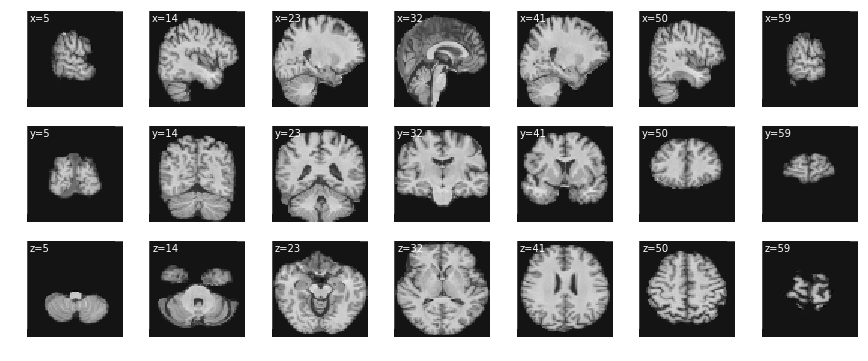

In [9]:
vis_utils.plot_slices(neg_ex)

tensor(-1.0387, dtype=torch.float64) tensor(2.4643, dtype=torch.float64) None None


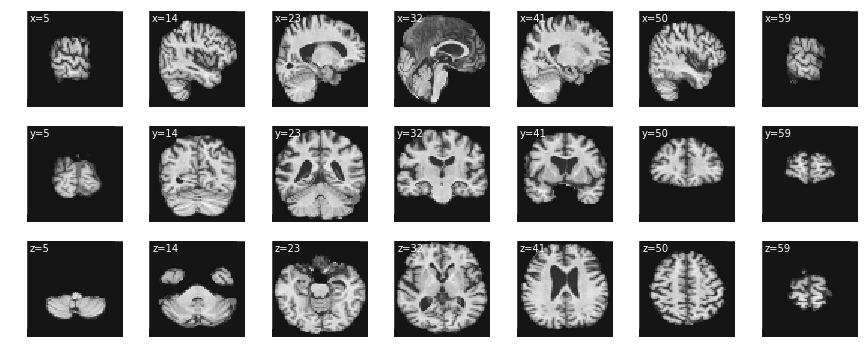

In [10]:
vis_utils.plot_slices(pos_ex)

In [11]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [12]:
# net.load_state_dict(torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model'])

In [13]:
net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])

<All keys matched successfully>

In [14]:
# for item in net.state_dict():
#     print(item)

# for item in torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model']:
#     print(item)

In [15]:
net.eval();

In [16]:
train_data[2000][0].shape
train_data[0][0].shape

(64, 64, 64)

In [17]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, pos_ex.shape, interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

In [18]:
def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    print(relevances.shape)
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)

In [ ]:
brain_map.shape

# Sensitivity Analysis

NC example:

In [19]:
relevance_map_backprop_neg = interpretation.sensitivity_analysis(net, test_data[11], cuda=False, verbose=True)

Image was classified as 0 with probability 0.9982078031171113
one hot output:  tensor([[[1.],
         [0.]]])


In [20]:
relevance_map_backprop_neg.shape

(1, 64, 64, 64)

-1.1001736853553332 2.533526221248398 1.2700951e-13 7.867203469686603e-06


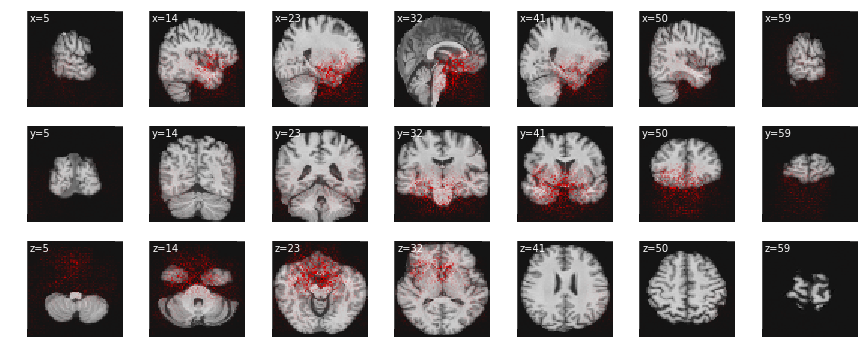

In [21]:
vis_utils.plot_slices(test_data[11][0], num_slices = 7, overlay=relevance_map_backprop_neg[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop_neg, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [22]:
get_relevance_per_area(relevance_map_backprop_neg[0])[:5]

(116,)


[('Temporal_Inf', 0.053981621151635295),
 ('Frontal_Inf_Orb', 0.04933422411682171),
 ('Frontal_Inf_Tri', 0.049313244291932984),
 ('Insula', 0.04887596855375636),
 ('Cingulum_Ant', 0.048765741096707005)]

AD example:

In [23]:
relevance_map_backprop_pos = interpretation.sensitivity_analysis(net, test_data[328], cuda=False, verbose=True)

Image was classified as 1 with probability 0.9967156648635864
one hot output:  tensor([[[0.],
         [1.]]])


-1.0386703576423546 2.4643422745714747 5.3930194e-12 0.000166195659781819


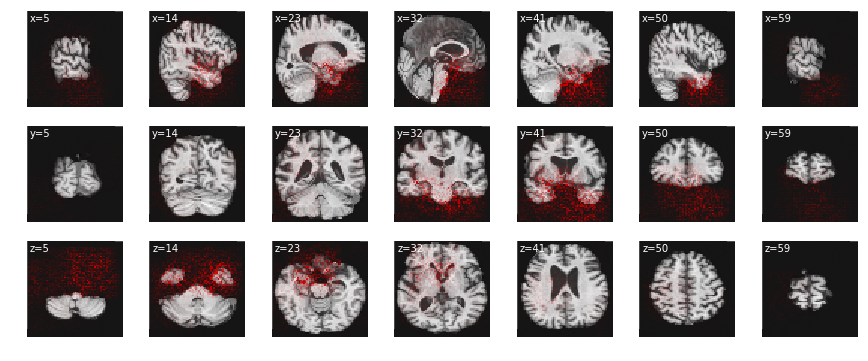

In [24]:
vis_utils.plot_slices(test_data[328][0], overlay=relevance_map_backprop_pos[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop_pos, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [25]:
get_relevance_per_area(relevance_map_backprop_pos[0])[:5]

(116,)


[('Temporal_Inf', 0.06935114452266158),
 ('Frontal_Inf_Orb', 0.055535115252224855),
 ('Insula', 0.048560237023222416),
 ('Temporal_Mid', 0.047078158221995584),
 ('Fusiform', 0.04323983934010564)]

# Guided Backprop

NC example:

In [ ]:
relevance_map_guided_neg = interpretation.guided_backprop(net, test_data[11], cuda=False, verbose=True)

In [ ]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_guided_neg[0], 
                  overlay_vmax=np.percentile(relevance_map_guided_neg, 99.9))

In [ ]:
get_relevance_per_area(relevance_map_guided_neg[0])[:5]

AD example:

In [ ]:
relevance_map_guided_pos = interpretation.guided_backprop(net, test_data[328], cuda=False, verbose=True)

In [ ]:
vis_utils.plot_slices(pos_ex, overlay=relevance_map_guided_pos[0], 
                  overlay_vmax=np.percentile(relevance_map_guided_pos, 99.9))

In [ ]:
get_relevance_per_area(relevance_map_guided_pos[0])[:5]

# Occlusion

NC example:

In [ ]:
relevance_map_occlusion_neg = interpretation.occlusion(net, test_data[11], size=10, stride=5, occlusion_value = 0, cuda=False, resize=True, verbose=True)

In [ ]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_occlusion_neg, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [ ]:
get_relevance_per_area(relevance_map_occlusion_neg[0])[:5]

In [ ]:
relevance_map_occlusion_pos = interpretation.occlusion(net, test_data[328], size=10, stride=5, cuda=False, resize=True, verbose=True)

In [ ]:
vis_utils.plot_slices(pos_ex, overlay=relevance_map_occlusion_pos, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [ ]:
get_relevance_per_area(relevance_map_occlusion_pos[0])[:5]

In [ ]:
# Plot occlusion patch on image.
occluded_image = train_data[0][0][:, 30, :].copy()
size = 20
occluded_image[10:10+size, 20:20+size] = 0
plt.imshow(occluded_image, cmap='gray')
plt.axis('off')

# Brain Area Occlusion

In [ ]:
relevance_map_area_occlusion_neg = interpretation.area_occlusion(net, test_data[11], area_masks, cuda=False, verbose=True)

In [ ]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_area_occlusion_neg, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)

In [ ]:
get_relevance_per_area(relevance_map_area_occlusion_neg)[:5]

AD positive:

In [ ]:
relevance_map_area_occlusion_pos = interpretation.area_occlusion(net, test_data[328], area_masks, cuda=False, verbose=True)

In [ ]:
vis_utils.plot_slices(test_data[328][0], overlay=relevance_map_area_occlusion_pos, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)

In [ ]:
get_relevance_per_area(relevance_map_area_occlusion_pos)[:5]

In [ ]:
test_mod = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [ ]:
for child in test_mod.children():
    print("CHILD:")
    for sub in child.children():
        print("SUB:")
        for mini in sub:
            print(mini)
            print("-------------------------------------------------------")